In [1]:
from pathlib import Path
import numpy as np
from scipy.signal import welch
from scipy.stats import stats
import matplotlib.pyplot as plt
import sys
sys.path.append("las-data-analysis")
from lda.pipeline.pipeline import Pipeline
from lda.pipeline.steps import STEP_PICO
from lda.pipeline.steps import STEP_VIVE
from lga.libs import error_checker

# Loading data
## 개요
* LDA 모듈을 이용해 data를 읽어오고 전처리하는 부분.
* 저장된 데이터의 파일 트리로부터 게임 이름을 읽지 않고 데이터를 우선 로딩한 후 meta info에서 게임 이름을 읽어온다.
    * PICO 데이터의 경우 VIVE와 다르게 파일 트리로부터 게임 이름을 알 수 있는 형태로 저장되지 않는다. 추후 PICO 데이터에 사용될 것도 고려하여 이렇게 구현하였다.
    * 타겟으로 하는 게임 이외의 파일들도 모두 한번씩 로딩하게 되므로 속도가 느린 단점이 있다.

## 함수 설명
### get_project_data_path(path_project, is_vive) -> path_dict
* path_project: 읽으려 하는 데이터들이 있는 디렉토리 path
* is_vive: VIVE 데이터라면 True, PICO라면 False
* path_dict: Dict["레코딩 이름"] = "레코딩 파일 path" 형태의 dict

### load_recording(path_data, is_vive) -> data_raw
* path_data: 하나의 레코딩파일 path
* is_vive: VIVE 데이터라면 True, PICO라면 False
* data_raw: 로딩한 데이터. LDA에 구현된 dataclass. 만약 데이터파일을 읽는 것이 불가능하다면 None으로 반환

### check_error(data_raw, is_vive) -> err_codes
* data_raw: 로딩한 데이터
* is_vive: VIVE 데이터라면 True, PICO라면 False.
* err_codes: 발생한 데이터 에러 리스트

### load_data(path_data, targets, label, is_vive=True) -> data
* path_project: 읽으려 하는 데이터들이 있는 디렉토리 path
* targets: 로딩할 게임 목록.
* label: 데이터에 붙일 라벨 이름.
* is_vive: VIVE 데이터라면 True, PICO라면 False.
* data: Dict[(game_name, user, label)] = preprocessed_data 형태의 dict.

### merge_data(data) -> merged
* data: **load_data**로 읽은 형태의 data dictionary
* merged: Dict[(user, label)][game_name] = preprocessed_data 형태의 dict. 데이터를 유저별로 합침.

In [2]:
def get_project_data_path(path_project, is_vive=True):
    path_project = Path(path_project)
    path_dict = dict()

    if is_vive:
        for path_meta in sorted(path_project.rglob(r"meta_info*.csv")):
            path_task = path_meta.parents[0]
            task_timestamp = path_meta.parents[0].name
            path_dict[task_timestamp] = path_task
    else:
        for path_zip in sorted(path_project.rglob(r"*.zip")):
            rec_name = path_zip.name
            path_dict[rec_name] = path_zip

    return path_dict


def load_recording(path_data, is_vive):
    try:
        data_raw = Pipeline.convert_data(path_data, is_vive=is_vive)
        return data_raw
    except Exception:
        return None


def check_error(data_raw, is_vive):
    game_name = data_raw.meta.app
    if is_vive:
        game_name = game_name.replace("_", "")
        
    err_codes = []
    err_codes += error_checker.data_empty_check(data_raw, game_name)
    err_codes += error_checker.eeg_overflow(data_raw)
    err_codes += error_checker.time_drift(data_raw)
    err_codes += error_checker.time_reversion(data_raw)
    err_codes += error_checker.head_movement(data_raw)
    err_codes += error_checker.eye_zero(data_raw, game_name)
    err_codes += error_checker.eye_noise(data_raw, is_vive, game_name)
    err_codes += error_checker.eeg_seq_num_check(data_raw, is_vive)

    return err_codes


def load_data(path_data, targets, label, is_vive=True):
    path_dict = get_project_data_path(path_data, is_vive)
    data = dict()
    for f_name, path in path_dict.items():
        print(path)
        # Load
        data_raw = load_recording(path, is_vive)
        if data_raw is None: continue
        
        # Check app name
        game_name = data_raw.meta.app
        if game_name not in targets: continue
            
        # Get user name
        if is_vive:
            user = data_raw.meta.user
        else:
            user = path.name.split("_")[0]
            
        # Error check
        err_code = check_error(data_raw, is_vive)
        if len({2, 3, 4, 5, 21, 22} & set(err_code)) != 0: continue
        
        # Preprocess
        step_preprocess = STEP_VIVE if is_vive else STEP_PICO
        data_prep = Pipeline.preprocess(step_preprocess, data_raw)
        data[(game_name, user, label)] = data_prep
        
    return data


def merge_data(data):
    merged = dict()
    for info, data_prep in data.items():
        game_name = info[0]
        user = info[1]
        info = (info[1], info[2])
        if info in merged.keys():
            merged[info][game_name] = data_prep
        else:
            merged[info] = {game_name: data_prep}
    
    return merged

In [4]:
data = dict()
# data.update(load_data("data/MCI", ["eegcalibration", "focusedattention", "trickyballs", "recall"], "MCI", False))
# data.update(load_data("data/HC", ["eegcalibration", "focusedattention", "trickyballs", "recall"], "HC", False))
data.update(load_data("data/MCI", ["eegcalibration", "focusedattention"], "MCI", False))
data.update(load_data("data/HC", ["eegcalibration", "focusedattention"], "HC", False))
data = merge_data(data)

data/MCI/com.looxidlabs.lucy.depthperception/5fc85d43f5117f001be9152e/5fc856e15ffc4c001b0f182e_1606966595504.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fc88c36f5117f001be91540/5fc87f835ffc4c001b0f1852_1606978614731.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fc9c12af5117f001be9158a/5fc87f835ffc4c001b0f1852_1607057706845.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fc9df8af5117f001be91591/5fc9c1f35ffc4c001b0f18d3_1607065482899.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fcd9780f5117f001be915a5/5fcd8d575ffc4c001b0f190f_1607309184087.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fcdb9fbf5117f001be915b0/5fcdb3215ffc4c001b0f1926_1607318011130.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fcee8fbf5117f001be915cd/5fced8ff9f94e8001c6da244_1607395579465.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fcf0ed4f5117f001be915d5/5fcf08d89f94e8001c6da262_1607405268899.zip
data/MCI/com.looxidlabs.lucy.depthperception/5fcf21a5f5117f001be915dd/5fcf1c159f94e8001c6da26e_1

In [74]:
list(data.keys()) # call subject information
# list(data.values()) # call data value

[('5fc856e15ffc4c001b0f182e', 'MCI'),
 ('5fc87f835ffc4c001b0f1852', 'MCI'),
 ('5fc9c1f35ffc4c001b0f18d3', 'MCI'),
 ('5fcd8d575ffc4c001b0f190f', 'MCI'),
 ('5fcdb3215ffc4c001b0f1926', 'MCI'),
 ('5fced8ff9f94e8001c6da244', 'MCI'),
 ('5fcf08d89f94e8001c6da262', 'MCI'),
 ('5fcf1c159f94e8001c6da26e', 'MCI'),
 ('5fd181649f94e8001c6da2a2', 'MCI'),
 ('5fd6f06e9f94e8001c6da2e7', 'MCI'),
 ('5fd6fb849f94e8001c6da309', 'MCI'),
 ('5fd821fafd7907001b289c84', 'MCI'),
 ('5fd855bcfd7907001b289ca7', 'MCI'),
 ('5fd992a6fd7907001b289cb5', 'MCI'),
 ('5fd9af6cfd7907001b289cdf', 'MCI'),
 ('5fdb061efd7907001b289cfa', 'MCI'),
 ('5fdc4344fd7907001b289d0b', 'MCI'),
 ('5fe04d36fd7907001b289d65', 'MCI'),
 ('5fe14caffd7907001b289da8', 'MCI'),
 ('5fe2e194fd7907001b289e38', 'MCI'),
 ('5fe416a92527b0001b994068', 'MCI'),
 ('5feaad2b5cc696001bba90af', 'MCI'),
 ('5feabed05cc696001bba90ba', 'MCI'),
 ('5ff3f5d55cc696001bba919b', 'MCI'),
 ('5fc869335ffc4c001b0f183b', 'HC'),
 ('5fc9e3f45ffc4c001b0f18f3', 'HC'),
 ('5fcdc6415ff

In [161]:
list(data.items())[0][1]['eegcalibration'].event 
print(list(data.items())[26][1]['eegcalibration'].eeg.shape)

(34522, 8)


In [179]:
sub = data[('5fc856e15ffc4c001b0f182e', 'MCI')]

In [180]:
print(sub["eegcalibration"].eeg.shape)
for k, v in sub["eegcalibration"].event.items():
    print(k)
    print(v)
    print() #space in between lines
    
print('------------------------------------------')

print(sub["focusedattention"].eeg.shape)
for k, v in sub["focusedattention"].event.items():
    print(k)
    print(v)
    print() #space in between lines

(34576, 8)
('scene', 'brainwave_test', '3')
{'event_category': 'scene', 'event_subcategory': 'brainwave_test', 'event_id': '3', 'event_type': 'instant', 'timestamp_st': 1606965656.535084, 'timestamp_en': None, 'event_detail_st': {}, 'event_detail_en': None}

('scene', 'eeg_calibration', '2')
{'event_category': 'scene', 'event_subcategory': 'eeg_calibration', 'event_id': '2', 'event_type': 'start-end', 'timestamp_st': 1606965596.537841, 'timestamp_en': 1606965656.534761, 'event_detail_st': {}, 'event_detail_en': {}}

('scene', 'instruction', '1')
{'event_category': 'scene', 'event_subcategory': 'instruction', 'event_id': '1', 'event_type': 'instant', 'timestamp_st': 1606965596.537089, 'timestamp_en': None, 'event_detail_st': {'contents': '이제 편안한 자세로 눈을 감고 있겠습니다. 삐 소리가 들릴 때 까지 눈을 감아주세요.'}, 'event_detail_en': None}

------------------------------------------
(81774, 8)
('click', 'attention_target', '6')
{'event_category': 'click', 'event_subcategory': 'attention_target', 'event_id': '6', 

# Crop EEG data from recordings
## 개요
* 전처리 된 데이터로부터 resting state EEG, fixation EEG, pursuit EEG를 잘라내는 부분

## 함수 설명
### extract_resting_EEG(data, margin=None) -> Dict["resting"]=eeg
* data: 전처리가 끝난 데이터. LDA의 dataclass object.
* margin: resting state 부분의 EEG를 잘라낼 때 앞뒤로 몇 샘플씩 버릴지 결정하는 파라미터. None 또는 0이면 버리지 않음.
* return: resting state EEG (이후 extract_data함수에서 합치기 편하도록 딕셔너리 형태로 반환)

### extract_smooth_pursuit(data, fixation_margin=None, pursuit_margin=None) -> extracted
* data: 전처리가 끝난 데이터. LDA의 dataclass object.
* fixation_margin: fixation 부분의 EEG를 잘라낼 때 앞뒤로 몇 샘플씩 버릴지 결정하는 파라미터. None 또는 0이면 버리지 않음.
* pursuit_margin: pursuit 부분의 EEG를 잘라낼 때 앞뒤로 몇 샘플씩 버릴지 결정하는 파라미터. None 또는 0이면 버리지 않음.
* extracted: fixation과 pursuit 할 때의 EEG를 dict 형태로 정리하여 반환. 키값은 "fixation_0", "fixation_1", ..., "pursuit_0", "pursuit_1", ...이며 각각에 해당하는 value가 잘라낸 EEG

### extract_data(data, resting_margin, fixation_margin, pursuit_margin) -> exts
* data: **Loading data** 파트의 **load_data** 함수로 읽은 데이터 dictionary
* resting_margin: resting state 부분의 EEG를 잘라낼 때 앞뒤로 몇 샘플씩 버릴지 결정하는 파라미터. None 또는 0이면 버리지 않음.
* fixation_margin: fixation 부분의 EEG를 잘라낼 때 앞뒤로 몇 샘플씩 버릴지 결정하는 파라미터. None 또는 0이면 버리지 않음.
* pursuit_margin: pursuit 부분의 EEG를 잘라낼 때 앞뒤로 몇 샘플씩 버릴지 결정하는 파라미터. None 또는 0이면 버리지 않음.
* exts: resting, fixation, pursuit EEG 데이터를 모두 모은 list of dict. 각 dict에는 EEG들과 데이터의 라벨, user이름이 들어있음.

In [368]:
samp_data = sub["focusedattention"]
def extract_focusedattention(samp_data, margin=None):
    trials = []
    for evt_info, evt in samp_data.event.items():
        if evt_info[0] == "trial":                           
            trials.append([evt["timestamp_st"], evt["timestamp_en"]])
     
    eeg = []
    for ts in trials:
        eeg.append(samp_data.eeg[(ts[0] <= samp_data.eeg[:, 0]) & (samp_data.eeg[:, 0] <= ts[1])])
    
#     print(len(eeg))
#     print(eeg[57].shape)
    print(eeg[0].shape)
    return {"focused": eeg}

In [369]:
test=extract_focusedattention(samp_data, margin=None)
test

(1734, 8)


{'focused': [array([[ 1.60696572e+09,  5.10000000e+01,  2.18670984e-05, ...,
           2.04549710e-05,  1.33952949e-05,  2.75270373e-05],
         [ 1.60696572e+09,  5.20000000e+01,  2.31225225e-05, ...,
           2.12199281e-05,  1.37702124e-05,  2.73678397e-05],
         [ 1.60696572e+09,  5.30000000e+01,  2.18551113e-05, ...,
           2.11900256e-05,  1.44094291e-05,  2.59014783e-05],
         ...,
         [ 1.60696573e+09,  2.46000000e+02,  6.63381771e-06, ...,
          -5.04107878e-06,  6.09290982e-07, -2.94723363e-06],
         [ 1.60696573e+09,  2.47000000e+02,  8.12558318e-06, ...,
          -5.43582686e-06, -2.51669915e-06, -3.26181872e-06],
         [ 1.60696573e+09,  2.48000000e+02,  1.01129064e-05, ...,
          -5.54012231e-06, -4.32766180e-06, -3.77018626e-06]]),
  array([[ 1.60696573e+09,  2.50000000e+02,  1.34501223e-05, ...,
          -4.42908070e-06, -2.91592423e-06, -3.64272781e-06],
         [ 1.60696573e+09,  2.51000000e+02,  1.32360054e-05, ...,
          -

In [437]:
def extract_resting_EEG(data, margin=None):
    
    for evt_info, evt in data.event.items():
        if evt_info[1] == "eeg_calibration":
            break
    ts_st, ts_en = evt["timestamp_st"], evt["timestamp_en"]
    eeg = data.eeg[(ts_st <= data.eeg[:, 0]) & (data.eeg[:, 0] <= ts_en)]
    
    if margin is not None and margin != 0:
        eeg = eeg[margin:-margin]

    return {"resting": [eeg]}


######
def extract_focusedattention(data, margin=None):
    trials = []
    for evt_info, evt in data.event.items():
        if evt_info[0] == "trial":                           
            trials.append([evt["timestamp_st"], evt["timestamp_en"]])
    eeg = []
    for ts in trials:
        eeg.append(data.eeg[(ts[0] <= data.eeg[:, 0]) & (data.eeg[:, 0] <= ts[1])])
    
    return {"focused": eeg}
######

def extract_data(data, resting_margin, focused_margin):
    exts = []
    for info, data_prep in data.items():
        ext = dict()
        if "eegcalibration" in data_prep.keys():
            ext.update(extract_resting_EEG(data_prep["eegcalibration"], resting_margin))
        if "focusedattention" in data_prep.keys():
            ext.update(extract_focusedattention(data_prep["focusedattention"],focused_margin))
        ext.update({"user": info[0], "label": info[1]})
        exts.append(ext)
    
    return exts

In [438]:
exts = extract_data(data, resting_margin=2500, focused_margin=None)

In [420]:
print(len(exts))
print(exts[37]['resting'].shape)
print(len(exts[37]['focused']))
print(exts[0]['focused'][0].shape)

38


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
plt.plot(exts[0]['resting'][100:1200, 2])

In [ ]:
plt.plot(exts[0]['focused'][0][100:1200, 2])

In [421]:
len(exts)

38

In [422]:
exts = extract_data(data, resting_margin=2500, focused_margin=None)

In [423]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 500  # Hertz
DURATION = 50  # Seconds
N = SAMPLE_RATE * DURATION

from scipy.fft import fft, fftfreq

yf = fft(exts[29]['resting'][0:1200, 7])  
# xf = fftfreq(N, 1 / SAMPLE_RATE) # original
xf = range(0,30) # just for plotting

plt.plot(xf, np.abs(yf[:30]))
plt.show()

TypeError: list indices must be integers or slices, not tuple

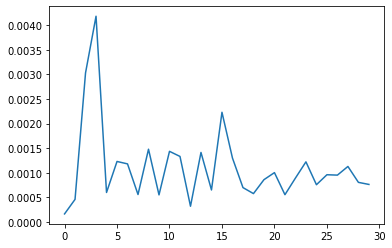

In [269]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 500  # Hertz
DURATION = 50  # Seconds
N = SAMPLE_RATE * DURATION

from scipy.fft import fft, fftfreq

yf = fft(exts[29]['focused'][0:1200, 7])  
# xf = fftfreq(N, 1 / SAMPLE_RATE) # original
xf = range(0,30) # just for plotting

plt.plot(xf, np.abs(yf[:30]))
plt.show()


# Preprocessing EEG to get PSDs
## 개요
* 전처리 된 데이터로부터 resting state EEG, fixation EEG, pursuit EEG를 잘라내는 부분

## 함수설명
### epoching(eeg, nperseg) -> epochs
* eeg: EEG 데이터
* nperseg: EEG 데이터를 여러 epoch로 나눌 때 한 epoch당 포함되는 샘플 수
* epochs: nperseg만큼의 길이로 나누어진 EEG epoch의 list

### psd_norm(psd) -> psd_norm
* psd: psd값. 첫번째 차원은 frequency, 두 번째 차원은 channel.
* normed: relative psd

### cal_PSD(epochs, nperseg) -> psds
* epochs: list of EEG epochs.
* nperseg: welch method의 window size.
* psds: list of (freq, psd). 각 EEG epoch별로 psd 계산 후 [1-50] 사이의 frequency만 잘라내어 리스트로 정리.

### preprocessing(exts, welch_nperseg, epoch_nperseg=None) -> preps
* exts: **Crop EEG data from recordings** 파트의 **extract_data**로 뽑아낸 데이터
* welch_nperseg: welch method의 window size.
* epoch_nperseg: EEG를 여러개의 epoch로 나눌 때 하나의 epoch에 포함될 샘플 개수. None이라면 epoching 하지 않음.
* preps: 전처리가 완료된 데이터. List of Dict. 각 dict는 하나의 레코딩에 대하여 user, label, resting psd, fixation psd, pursuit psd를 포함.

In [452]:
def epoching(eegs, nperseg):
    epochs = []
    for eeg in eegs:
        epochs += [eeg[i*nperseg : (i + 1)*nperseg] for i in range(len(eeg) // nperseg)] 

    return epochs


def psd_norm(psd):
    denom = psd.sum(axis=0, keepdims=True)
    normed = psd / denom
    
    return normed

    
def cal_PSD(epochs, nperseg):
    psds = []
    for epoch in epochs:
        f, psd = welch(epochs[0][:, 2:], fs=500, nperseg=nperseg, axis=0, window="hamming")
        idx_crop = (1 <= f) & (f <= 50)
        f = f[idx_crop]
        psd = psd[idx_crop]
        psd = psd_norm(psd)
        psd = psd.mean(axis=1)
        
        psds.append((f, psd))
    
    return psds
    

def preprocessing(exts, welch_nperseg, epoch_nperseg=None):
    preps = []
    for ext in exts:
        prep = {"user": ext["user"], "label": ext["label"],
                "resting": [], "focused": []}
        
        for key, val in ext.items():
            if key in ["user", "label"]: continue
            if epoch_nperseg:
                epochs = epoching(ext[key], epoch_nperseg) # 3s epochs
            else:
                epochs = ext[key]
            psds = cal_PSD(epochs, welch_nperseg)
            prep[key.split("_")[0]].extend(psds)
        preps.append(prep)
    
    return preps

In [461]:
preps = preprocessing(exts, welch_nperseg=500, epoch_nperseg=None)

In [462]:
len(preps[0]["focused"])

58

In [463]:
preps[4]['focused'][0]

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 array([0.25080864, 0.25676801, 0.20719228, 0.08592205, 0.03514014,
        0.01896135, 0.01576462, 0.01222665, 0.0073265 , 0.00930363,
        0.00965218, 0.00596855, 0.0049189 , 0.00296998, 0.00311481,
        0.00462995, 0.00490455, 0.00208119, 0.00416443, 0.0038984 ,
        0.00516022, 0.00503242, 0.00207647, 0.00191896, 0.00390268,
        0.00221766, 0.00124283, 0.00089588, 0.00162631, 0.003184  ,
        0.00177859, 0.00198456, 0.00178401, 0.00113799, 0.00146528,
        0.00129778, 0.00165566, 0.00330761, 0.00200534, 0.00237102,
        0.00111031, 0.00094388, 0.00127455, 0.00132079, 0.00077904,
        0.00046105, 0.00041022, 0.0006275 , 0.00066318, 0.00064738]))

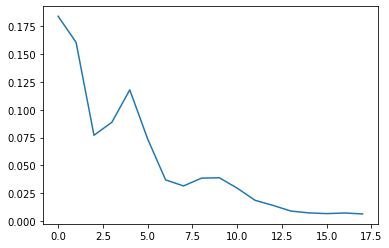

In [475]:
plt.plot(preps[4]['resting'][0][1][:18])

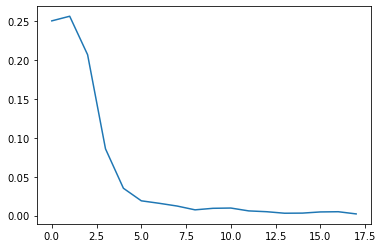

In [474]:
plt.plot(preps[4]['focused'][0][1][:18])

# Result: Eye Close PSD vs. Eye Open PSD
* AD군에서 eye close alpha가 낮게 나타남
* 결과에 대한 상세 설명, 주장하려는 논리 구조는 [AD군의 alpha wave 분석](https://looxidlabs.atlassian.net/wiki/spaces/~283200371/pages/947913009/Alpha+wave) 참고

In [14]:

resting_psd = {"MCI": [], "HC": []}
fixation_psd = {"MCI": [], "HC": []}
pursuit_psd = {"MCI": [], "HC": []}

for prep in preps:
    label = prep["label"]
    f = prep["resting"][0][0]
    resting_psd[label].extend([psd[1] for psd in prep["resting"]])
    fixation_psd[label].extend([psd[1] for psd in prep["fixation"]])
    pursuit_psd[label].extend([psd[1] for psd in prep["pursuit"]])


def plot_fig(f, EC, EO, label, ax):
    EC_mean = np.mean(EC[label], axis=0)
    EC_err = stats.sem(EC[label], axis=0)
    ax.plot(f, EC_mean, label="EC", c="tab:blue")
    ax.fill_between(f, EC_mean - EC_err, EC_mean + EC_err, color="tab:blue", alpha=0.3)
    
    EO_mean = np.mean(EO[label], axis=0)
    EO_err = stats.sem(EO[label], axis=0)
    ax.plot(f, EO_mean, label="EO", c="tab:red")
    ax.fill_between(f, EO_mean - EO_err, EO_mean + EO_err, color="tab:red", alpha=0.3)
    
    ax.set_xlim([1, 15])
    ax.set_ylim([0, 0.1])
    
    
fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharey="row")
"""
Fixaiton (SNUH) | Fixation (Nold) | Fixation (Looxid)
Pursuit  (SNUH) | Pursuit  (Nold) | Pursuit  (Looxid)
"""    
ax[0, 0].set_title("Fixation - MCI")
plot_fig(f, resting_psd, fixation_psd, "MCI", ax[0, 0])
ax[0, 1].set_title("Fixation - HC")
plot_fig(f, resting_psd, fixation_psd, "HC", ax[0, 1])
ax[1, 0].set_title("Pursuit - MCI")
plot_fig(f, resting_psd, pursuit_psd, "MCI", ax[1, 0])
ax[1, 1].set_title("Pursuit - HC")
plot_fig(f, resting_psd, pursuit_psd, "HC", ax[1, 1])

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, ncol=1, loc="center right", bbox_to_anchor=(1.1, 0.9))
fig.text(0.52, -0.01, 'Frequency (Hz)', ha='center', size="x-large")
fig.text(-0.03, 0.45, 'Relative PSD', ha='center', rotation=90, size="x-large")
fig.suptitle("Relative PSD", x=0.52, y=1.05, size="xx-large")
fig.set_tight_layout(True)

IndexError: list index out of range